<a href="https://colab.research.google.com/github/parvezmosaraf/Machine-Learning-Project/blob/main/Electricity_load_prediction_using_GRU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd

import numpy as np

from keras import callbacks
from keras import layers, models

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [26]:
df_total = pd.read_csv("/content/drive/MyDrive/Electricity load/electricity.csv")
df_total.index = pd.to_datetime(df_total['date'], format='%m/%d/%Y')

In [27]:
df = df_total[["electricity load actual", "demand_actual"]]
df = df.rename(columns={"electricity load actual": "electricity_load", "demand_actual": "pred_demand"})
df_total

,time,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday,trend,load forecast,electricity load actual,demand_day,demand_actual
date,,,,,,,,,,,,,,,,,,,
2003-03-01,NaN,CT,3386.0,25.0,19.0,3/1/2003,2003,Mar,1,Sat,60,True,NaN,False,0.0,26118.0,25385.0,50.10,65.41
2003-03-01,3/1/2003 1:00,CT,3258.0,23.0,18.0,3/1/2003,2003,Mar,2,Sat,60,True,NaN,False,1.0,24934.0,24382.0,48.10,64.92
2003-03-01,3/1/2003 2:00,CT,3189.0,22.0,18.0,3/1/2003,2003,Mar,3,Sat,60,True,NaN,False,2.0,23515.0,22734.0,47.33,64.48
2003-03-01,3/1/2003 3:00,CT,3157.0,22.0,19.0,3/1/2003,2003,Mar,4,Sat,60,True,NaN,False,3.0,22642.0,21286.0,42.27,59.32
2003-03-01,3/1/2003 4:00,CT,3166.0,23.0,19.0,3/1/2003,2003,Mar,5,Sat,60,True,NaN,False,4.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-17,6/17/2009 15:00,VT,728.0,75.0,49.0,6/17/2009,2009,Jun,16,Wed,168,False,NaN,False,55215.0,NaN,NaN,NaN,NaN
2009-06-17,6/17/2009 16:00,VT,720.0,75.0,42.0,6/17/2009,2009,Jun,17,Wed,168,False,NaN,False,55216.0,NaN,NaN,NaN,NaN
2009-06-17,6/17/2009 17:00,VT,714.0,74.0,46.0,6/17/2009,2009,Jun,18,Wed,168,False,NaN,False,55217.0,NaN,NaN,NaN,NaN


In [28]:
df = df_total.drop(['time','zone','day_of_year','holiday_name','weekend','load forecast','trend'], axis = 1)
df

,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,holiday,electricity load actual,demand_day,demand_actual
date,,,,,,,,,,,,
2003-03-01,3386.0,25.0,19.0,3/1/2003,2003,Mar,1,Sat,False,25385.0,50.10,65.41
2003-03-01,3258.0,23.0,18.0,3/1/2003,2003,Mar,2,Sat,False,24382.0,48.10,64.92
2003-03-01,3189.0,22.0,18.0,3/1/2003,2003,Mar,3,Sat,False,22734.0,47.33,64.48
2003-03-01,3157.0,22.0,19.0,3/1/2003,2003,Mar,4,Sat,False,21286.0,42.27,59.32
2003-03-01,3166.0,23.0,19.0,3/1/2003,2003,Mar,5,Sat,False,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-17,728.0,75.0,49.0,6/17/2009,2009,Jun,16,Wed,False,NaN,NaN,NaN
2009-06-17,720.0,75.0,42.0,6/17/2009,2009,Jun,17,Wed,False,NaN,NaN,NaN
2009-06-17,714.0,74.0,46.0,6/17/2009,2009,Jun,18,Wed,False,NaN,NaN,NaN


In [29]:
# checking for missing values
df.isnull().sum()

demand                          0
drybulb                         0
dewpnt                          0
date                            0
year                            0
month                           0
hour                            0
day_of_week                     0
holiday                         0
electricity load actual    993793
demand_day                 993757
demand_actual              993757
dtype: int64

In [30]:
df['electricity load actual'] = df['electricity load actual'].fillna(method = 'bfill')
df['demand_day'] = df['demand_day'].fillna(method = 'bfill')
df['demand_actual'] = df['demand_actual'].fillna(method = 'bfill')

**Handle the null value**


In [35]:
df.dropna(subset=["electricity load actual", "demand_day", "demand_actual"])

,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,holiday,electricity load actual,demand_day,demand_actual
date,,,,,,,,,,,,
2003-03-01,3386.0,25.0,19.0,3/1/2003,2003,Mar,1,Sat,False,25385.0,50.10,65.41
2003-03-01,3258.0,23.0,18.0,3/1/2003,2003,Mar,2,Sat,False,24382.0,48.10,64.92
2003-03-01,3189.0,22.0,18.0,3/1/2003,2003,Mar,3,Sat,False,22734.0,47.33,64.48
2003-03-01,3157.0,22.0,19.0,3/1/2003,2003,Mar,4,Sat,False,21286.0,42.27,59.32
2003-03-01,3166.0,23.0,19.0,3/1/2003,2003,Mar,5,Sat,False,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2007-03-01,3474.0,26.0,16.0,3/1/2007,2007,Mar,6,Thu,False,28071.0,66.88,74.30
2007-03-01,4022.0,25.0,16.0,3/1/2007,2007,Mar,7,Thu,False,25801.0,63.93,69.89
2007-03-01,4290.0,24.0,16.0,3/1/2007,2007,Mar,8,Thu,False,24455.0,64.27,69.88


In [37]:
def fill_nans(df, column_name):
    dfc = df[column_name]
    nans_num = np.sum(np.isnan(dfc))
        
    dfc = dfc.interpolate(method='linear', axis=0).ffill().bfill()
    df[column_name] = dfc
    
    print(f"Interpolated {nans_num} NaNs in column '{column_name}'.")

fill_nans(df, "demand_actual")
fill_nans(df, "electricity load actual")

Interpolated 993757 NaNs in column 'demand_actual'.
Interpolated 993757 NaNs in column 'electricity load actual'.


In [38]:
time_normalization = {
    "hour": lambda time: time / 24,
    "day_of_week": lambda time: time / 7,
    "month": lambda time: (time - 1) / 12,
}

datetimes = time_column.to_series().dt

for time_property, normalize_time_func in time_normalization.items():
    time = getattr(datetimes, time_property)
    time_normalized = normalize_time_func(time) 
    df[time_property] = time_normalized
    
df

,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,holiday,electricity load actual,demand_day,demand_actual
date,,,,,,,,,,,,
2003-03-01,3386.0,25.0,19.0,3/1/2003,2003,0.166667,0.0,0.714286,False,25385.0,50.10,65.41
2003-03-01,3258.0,23.0,18.0,3/1/2003,2003,0.166667,0.0,0.714286,False,24382.0,48.10,64.92
2003-03-01,3189.0,22.0,18.0,3/1/2003,2003,0.166667,0.0,0.714286,False,22734.0,47.33,64.48
2003-03-01,3157.0,22.0,19.0,3/1/2003,2003,0.166667,0.0,0.714286,False,21286.0,42.27,59.32
2003-03-01,3166.0,23.0,19.0,3/1/2003,2003,0.166667,0.0,0.714286,False,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-17,728.0,75.0,49.0,6/17/2009,2009,0.416667,0.0,0.285714,False,24455.0,NaN,69.88
2009-06-17,720.0,75.0,42.0,6/17/2009,2009,0.416667,0.0,0.285714,False,24455.0,NaN,69.88
2009-06-17,714.0,74.0,46.0,6/17/2009,2009,0.416667,0.0,0.285714,False,24455.0,NaN,69.88


In [39]:
past_time_stamps = 24
target_time = 24
total_time_window = past_time_stamps + target_time

# 2016 is a leap year
train_split = (365 + 366) * 24
val_split = train_split + 365 * 24

X_attr = df[["electricity load actual", "demand_actual"]].to_numpy()
# time properties are already normalized
X_time_norm = df[["hour", "day_of_week", "month"]].to_numpy()
Y_price = df[["demand_actual"]].to_numpy()
Y_load = df[["electricity load actual"]].to_numpy()

# X will be shifted later
# shift Y values 48h ahead
X_attr_train = X_attr[:train_split]
X_time_train_norm = X_time_norm[:train_split]
Y_load_train = Y_load[total_time_window:train_split]
Y_price_train = Y_price[total_time_window:train_split]

X_attr_val = X_attr[train_split:val_split]
X_time_val_norm = X_time_norm[train_split:val_split]
Y_load_val = Y_load[train_split+total_time_window:val_split]
Y_price_val = Y_price[train_split+total_time_window:val_split]

X_attr_test = X_attr[val_split:]
X_time_test_norm = X_time_norm[val_split:]
Y_load_test = Y_load[val_split+total_time_window:]
Y_price_test = Y_price[val_split+total_time_window:]

X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.fit(X_attr_train)
X_attr_train_norm = X_scaler.transform(X_attr_train)
X_attr_val_norm = X_scaler.transform(X_attr_val)
X_attr_test_norm = X_scaler.transform(X_attr_test)

Y_load_scaler = MinMaxScaler(feature_range=(0, 1))
Y_load_scaler.fit(Y_load_train)
Y_load_train_norm = Y_load_scaler.transform(Y_load_train)
Y_load_val_norm = Y_load_scaler.transform(Y_load_val)
Y_load_test_norm = Y_load_scaler.transform(Y_load_test)

Y_price_scaler = MinMaxScaler(feature_range=(0, 1))
Y_price_scaler.fit(Y_price_train)
Y_price_train_norm = Y_price_scaler.transform(Y_price_train)
Y_price_val_norm = Y_price_scaler.transform(Y_price_val)
Y_price_test_norm = Y_price_scaler.transform(Y_price_test)

def to_time_windows(X):
    time_windows = []

    # use past measurements between 0..23h
    for i in range(past_time_stamps):
        time_windows.append(X[i:-total_time_window+i, :])

    time_windows = np.stack(time_windows, axis=1)
    return time_windows

# those will be used with the baseline models
X_attr_time_train_norm = np.concatenate([X_attr_train_norm, X_time_train_norm], axis=1)
X_attr_time_val_norm = np.concatenate([X_attr_val_norm, X_time_val_norm], axis=1)
X_attr_time_test_norm = np.concatenate([X_attr_test_norm, X_time_test_norm], axis=1)

X_attr_time_train_norm_windows = to_time_windows(X_attr_time_train_norm)
X_attr_time_val_norm_windows = to_time_windows(X_attr_time_val_norm)
X_attr_time_test_norm_windows = to_time_windows(X_attr_time_test_norm)

# those will be used with our model
X_attr_train_norm_windows = to_time_windows(X_attr_train_norm)
X_attr_val_norm_windows = to_time_windows(X_attr_val_norm)
X_attr_test_norm_windows = to_time_windows(X_attr_test_norm)

X_time_train_norm_values = X_time_train_norm[past_time_stamps:-target_time]
X_time_val_norm_values = X_time_val_norm[past_time_stamps:-target_time]
X_time_test_norm_values = X_time_test_norm[past_time_stamps:-target_time]

print("Train data", X_attr_time_train_norm_windows.shape, X_attr_train_norm_windows.shape, 
      X_time_train_norm_values.shape, Y_load_train_norm.shape, Y_price_train_norm.shape)
print("Validation data", X_attr_time_val_norm_windows.shape, X_attr_val_norm_windows.shape, 
      X_time_val_norm_values.shape, Y_load_val_norm.shape, Y_price_val_norm.shape)
print("Test data", X_attr_time_test_norm_windows.shape, X_attr_test_norm_windows.shape, 
      X_time_test_norm_values.shape, Y_load_test_norm.shape, Y_price_test_norm.shape)

Train data (17496, 24, 5) (17496, 24, 2) (17496, 3) (17496, 1) (17496, 1)
Validation data (8712, 24, 5) (8712, 24, 2) (8712, 3) (8712, 1) (8712, 1)
Test data (1002471, 24, 5) (1002471, 24, 2) (1002471, 3) (1002471, 1) (1002471, 1)


In [40]:
n_features = X_attr_time_train_norm_windows.shape[2]

def lstm_model():
    model = models.Sequential(name="LSTM")
    model.add(layers.LSTM(25, input_shape=(past_time_stamps, n_features)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))

    return model

def cnn_model():
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(past_time_stamps, n_features)),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128),
        layers.Dropout(0.3),
        layers.Dense(1)
    ], name="CNN")
    
    return model

def run_xgboost(column_to_predict, x_train_norm, y_train_norm, x_val_norm, y_val_norm, x_test_norm, y_test_norm, y_scaler, y_val, y_test):    
    x_train_xgb = x_train_norm.reshape(-1, x_train_norm.shape[1] * x_train_norm.shape[2])
    x_val_xgb = x_val_norm.reshape(-1, x_val_norm.shape[1] * x_val_norm.shape[2])
    x_test_xgb = x_test_norm.reshape(-1, x_test_norm.shape[1] * x_test_norm.shape[2])
    
    param = {'eta': 0.03, 'max_depth': 180, 
             'subsample': 1.0, 'colsample_bytree': 0.95, 
             'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
             'objective': 'reg:linear', 'eval_metric': 'mae', 
             'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}
    
    dtrain = xgb.DMatrix(x_train_xgb, y_train_norm)
    dval = xgb.DMatrix(x_val_xgb, y_val_norm)
    dtest = xgb.DMatrix(x_test_xgb, y_test_norm)
    eval_list = [(dtrain, 'train'), (dval, 'val')]
    
    evals_result = {}
    xgb_model = xgb.train(param, dtrain, 180, eval_list, evals_result=evals_result, verbose_eval=False)
    
    y_val_pred_norm = xgb_model.predict(dval)
    y_val_pred_norm = y_val_pred_norm.reshape(-1, 1)
    y_val_pred = y_scaler.inverse_transform(y_val_pred_norm)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    print('XGBoost - MAE on validation dataset', round(mae_val, 2))
    
    y_test_pred_norm = xgb_model.predict(dtest)
    y_test_pred_norm = y_test_pred_norm.reshape(-1, 1)
    y_test_pred = y_scaler.inverse_transform(y_test_pred_norm)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print('XGBoost - MAE on test dataset', round(mae_test, 2))
    
    history = {
        "loss": evals_result['train']['mae'],
        "val_loss": evals_result['val']['mae']
    }

    plot_loss(history)
    plot_prediction(column_to_predict, y_val, y_val_pred)
    
lstm_load_model = lstm_model()
lstm_price_model = lstm_model()
lstm_price_model.summary()

print("\n\n")
cnn_load_model = cnn_model()
cnn_price_model = cnn_model()
cnn_price_model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 25)                3100      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3,126
Trainable params: 3,126
Non-trainable params: 0
_________________________________________________________________



Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 19, 64)            1984      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 64) 

In [41]:
def gru_encoder(time_series):
    x = layers.GRU(units=16)(time_series)

    return [x, "GRU"]


def cnn_encoder(time_series): 
    num_filters = 8
       
    x = layers.Conv1D(num_filters * 1, 3, activation="relu", padding="same")(time_series)
    x = layers.Conv1D(num_filters * 2, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv1D(num_filters * 2, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(num_filters * 3, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv1D(num_filters * 3, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(num_filters * 4, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv1D(num_filters * 4, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    
    return [x, "CNN"]


def conv_encoder(time_series):
    x = tf.transpose(time_series, [0, 2, 1])
    x = layers.Conv1D(16, 3, padding="same", activation="linear")(x)
    x = layers.Conv1D(8, 3, padding="same", activation="linear")(x)
    x = layers.Conv1D(4, 3, padding="same", activation="linear")(x)
    x = layers.Flatten()(x)
    
    return [x, "CONV"]


def concat_model(feature_encoder):
    # past 24 timestamps of load and price
    time_windows = layers.Input((past_time_stamps, 2))
    # hour, day of the week, month of the time stamp when the forecast happens
    time_values = layers.Input((3))
    
    x, encoder_name = feature_encoder(time_windows)
    y = layers.Dense(16, activation="relu")(time_values)
    x = layers.Concatenate()([x, y])
    
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Dense(1)(x)

    model = models.Model(inputs = [time_windows, time_values], outputs=x, 
                         name=f"{encoder_name}_concat_time")
    
    return model

gru_concat_time_load_model = concat_model(gru_encoder)
gru_concat_time_price_model = concat_model(gru_encoder)
gru_concat_time_price_model.summary()

print("\n\n")
cnn_concat_time_load_model = concat_model(cnn_encoder)
cnn_concat_time_price_model = concat_model(cnn_encoder)
cnn_concat_time_price_model.summary()

print("\n\n")
conv_concat_time_load_model = concat_model(conv_encoder)
conv_concat_time_price_model = concat_model(conv_encoder)
conv_concat_time_price_model.summary()

Model: "GRU_concat_time"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 2)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 gru_1 (GRU)                    (None, 16)           960         ['input_3[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 16)           64          ['input_4[0][0]']                
                                                                                    

In [42]:
def plot_loss(history):
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

two_weeks = 24 * 14
x = time_column.to_series().to_numpy()[train_split+total_time_window:train_split+total_time_window+two_weeks]
    
def plot_prediction(column_to_predict, y_true, y_pred):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M', tz=time_column.tz))
    plt.title(f"Electricity {column_to_predict}")
    plt.plot(x, y_true[:two_weeks])
    plt.plot(x, y_pred[:two_weeks])
    plt.legend(['ground truth', 'prediction'], loc='upper left')
    plt.gcf().autofmt_xdate()
    plt.show()

In [43]:
epochs = 20
# 0 - no output, 1 - detailed output, 2 - brief output
verbosity = 0

def run_model(model, column_to_predict, x_train_norm, y_train_norm, x_val_norm, y_val_norm, x_test_norm, y_scaler, y_val, y_test):
    weights_path = f"{model.name}_{column_to_predict}_weights.h5"

    modelckpt_callback = callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=weights_path,
        verbose=verbosity,
        save_weights_only=True,
        save_best_only=True,
    )
    
    model.compile(loss='mae', optimizer="adam")

    history = model.fit(x_train_norm, y_train_norm, epochs=epochs, 
              validation_data=(x_val_norm, y_val_norm),
              callbacks=[modelckpt_callback],
              verbose=verbosity)
    
    model.load_weights(weights_path)

    y_val_pred_norm = model.predict(x_val_norm)
    y_val_pred = y_scaler.inverse_transform(y_val_pred_norm)

    mae_val = mean_absolute_error(y_val, y_val_pred)
    print(f"{model.name} - MAE on validation dataset", round(mae_val, 2))

    y_test_pred_norm = model.predict(x_test_norm)
    y_test_pred = y_scaler.inverse_transform(y_test_pred_norm)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f"{model.name} - MAE on test dataset", round(mae_test, 2))
    
    plot_loss(history.history)
    plot_prediction(column_to_predict, y_val, y_val_pred)

273/273 [==============================] - 1s 2ms/step
LSTM - MAE on validation dataset 1833.84
31328/31328 [==============================] - 66s 2ms/step
LSTM - MAE on test dataset 2299.11


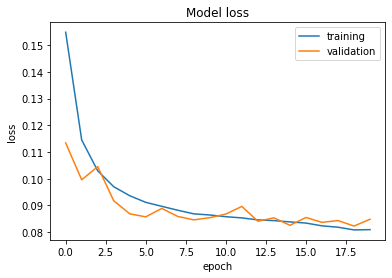

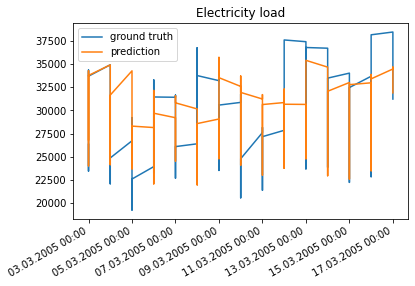

In [44]:
run_model(lstm_load_model, "load", 
          X_attr_time_train_norm_windows, Y_load_train_norm, 
          X_attr_time_val_norm_windows, Y_load_val_norm, 
          X_attr_time_test_norm_windows, Y_load_scaler, Y_load_val, Y_load_test)

273/273 [==============================] - 1s 2ms/step
CNN - MAE on validation dataset 2028.35
31328/31328 [==============================] - 69s 2ms/step
CNN - MAE on test dataset 3756.6


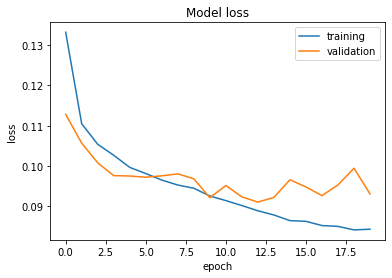

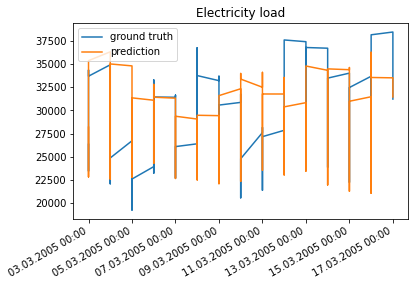

In [45]:
run_model(cnn_load_model, "load",
          X_attr_time_train_norm_windows, Y_load_train_norm, 
          X_attr_time_val_norm_windows, Y_load_val_norm, 
          X_attr_time_test_norm_windows, Y_load_scaler, Y_load_val, Y_load_test)

XGBoost - MAE on validation dataset 1777.17
XGBoost - MAE on test dataset 4735.0


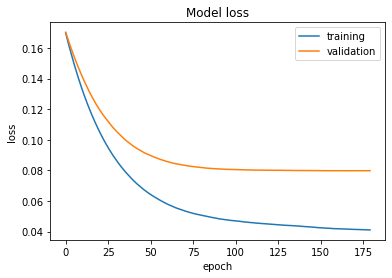

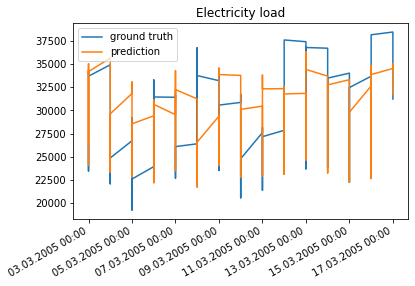

In [46]:
run_xgboost("load", 
            X_attr_time_train_norm_windows, Y_load_train_norm, 
            X_attr_time_val_norm_windows, Y_load_val_norm, 
            X_attr_time_test_norm_windows, Y_load_test_norm, 
            Y_load_scaler, Y_load_val, Y_load_test)

**OVIJIT** BROTHER , HERE IS YOUR **electricity load prediction using GRU algorithm**

273/273 [==============================] - 1s 2ms/step
GRU_concat_time - MAE on validation dataset 1871.14
31328/31328 [==============================] - 70s 2ms/step
GRU_concat_time - MAE on test dataset 1369.05


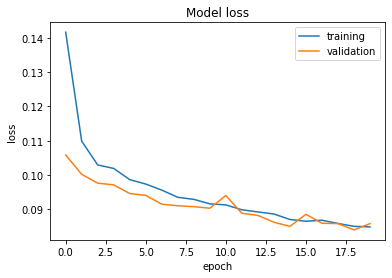

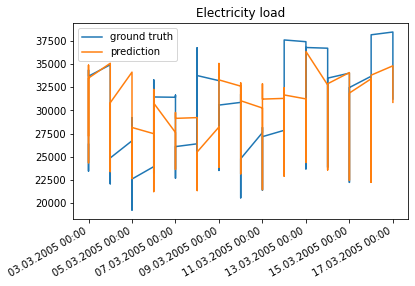

In [47]:
run_model(gru_concat_time_load_model, "load",
          [X_attr_train_norm_windows, X_time_train_norm_values], Y_load_train_norm, 
          [X_attr_val_norm_windows, X_time_val_norm_values], Y_load_val_norm, 
          [X_attr_test_norm_windows, X_time_test_norm_values], Y_load_scaler, Y_load_val, Y_load_test)